# Designing a covariate for the mutation of cancer genes

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from time import time
from typing import Union

import arviz as az
import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc as pm
import pymc.math as pmmath

In [3]:
from speclet.analysis.arviz_analysis import extract_matrix_variable_coords
from speclet.bayesian_models.hierarchical_nb import HierarchcalNegativeBinomialModel
from speclet.data_processing.common import get_cats
from speclet.data_processing.crispr import common_indices
from speclet.io import DataFile
from speclet.managers.data_managers import CrisprScreenDataManager
from speclet.plot.plotnine_helpers import set_gg_theme
from speclet.project_configuration import read_project_configuration

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_gg_theme()
%config InlineBackend.figure_format = "retina"

# Constants
RANDOM_SEED = 816
np.random.seed(RANDOM_SEED)
HDI_PROB = read_project_configuration().modeling.highest_density_interval

## Load data

In [5]:
counts_data = CrisprScreenDataManager(DataFile.DEPMAP_CRC_BONE_SUBSAMPLE).get_data()
counts_data.head()

,sgrna,replicate_id,lfc,p_dna_batch,genome_alignment,hugo_symbol,screen,multiple_hits_on_gene,sgrna_target_chr,sgrna_target_pos,...,num_mutations,any_deleterious,any_tcga_hotspot,any_cosmic_hotspot,is_mutated,copy_number,lineage,primary_or_metastasis,is_male,age
0,CGGAGCCTCGCCATTCCCGA,COLO201-311Cas9_RepA_p6_batch3,-0.183298,3,chr9_136410332_-,ENTR1,broad,True,9,136410332,...,0,NaN,NaN,NaN,False,1.064776,colorectal,metastasis,True,70.0
1,AAATAATTAAGTATGCACAT,COLO201-311Cas9_RepA_p6_batch3,-1.102995,3,chr13_48081696_-,MED4,broad,True,13,48081696,...,0,NaN,NaN,NaN,False,1.582238,colorectal,metastasis,True,70.0
2,AACAGCTGTTTACCAAGCGA,COLO201-311Cas9_RepA_p6_batch3,-0.991020,3,chr13_48083409_-,MED4,broad,True,13,48083409,...,0,NaN,NaN,NaN,False,1.582238,colorectal,metastasis,True,70.0
3,AATCAACCCACAGCTGCACA,COLO201-311Cas9_RepA_p6_batch3,0.219207,3,chr17_7675183_+,TP53,broad,True,17,7675183,...,0,NaN,NaN,NaN,False,0.978003,colorectal,metastasis,True,70.0
4,ACAAGGGGCGACCGTCGCCA,COLO201-311Cas9_RepA_p6_batch3,0.003980,3,chr8_103415011_-,DCAF13,broad,True,8,103415011,...,0,NaN,NaN,NaN,False,1.234548,colorectal,metastasis,True,70.0


## Create hierarchical NB model object

In [6]:
hnb = HierarchcalNegativeBinomialModel()

In [7]:
valid_counts_data = hnb.data_processing_pipeline(counts_data)

## Modify the data

A fake dictionary of cancer genes per lineage.

In [8]:
cancer_genes = {
    "colorectal": {"KRAS", "APC", "PIK3CA"},
    "bone": {"TP53", "SCRG1"},
}

I modified the data to insert a synthetic lethal interaction in each lineage.

- for `colorectal`, there is a **reduction** in the final count of *DCAF13* when *KRAS* is mutated
- for `bone`, there is an **increase** in the final count of *MED4* when *SCRG1* is mutated

In [9]:
def _modify_comutation(
    df: pd.DataFrame, target: str, cancer_gene: str, lineage: str, change: float
) -> pd.DataFrame:
    genes = valid_counts_data.hugo_symbol.values
    lineages = valid_counts_data.lineage.values
    cell_lines = valid_counts_data.depmap_id.values

    cancer_muts = (
        valid_counts_data.query(
            f"hugo_symbol == '{cancer_gene}' and lineage == '{lineage}'"
        )
        .query("is_mutated")
        .depmap_id.unique()
        .astype(str)
    )

    ary = (
        (lineages == lineage)
        * (genes == target)
        * [c in cancer_muts for c in cell_lines]
    )
    print(f"number of changes: {sum(ary)}")

    ct_final = valid_counts_data["counts_final"].values
    ct_final[ary] = ct_final[ary] * change
    valid_counts_data["counts_final"] = ct_final
    return valid_counts_data

In [10]:
comutation_changes = [
    {"target": "ADH1B", "cancer_gene": "KRAS", "lineage": "colorectal", "change": 0.2},
    {"target": "MED4", "cancer_gene": "SCRG1", "lineage": "bone", "change": 2.0},
]
for change_info in comutation_changes:
    valid_counts_data = _modify_comutation(valid_counts_data, **change_info)  # type: ignore

number of changes: 3
number of changes: 4


## Covariate design and model construction

In [11]:
def _collect_all_cancer_genes(cancer_genes: dict[str, set[str]]) -> list[str]:
    gene_set: set[str] = set()
    for genes in cancer_genes.values():
        gene_set = gene_set.union(genes)
    gene_list = list(gene_set)
    gene_list.sort()
    return gene_list


def _collect_mutations_per_cell_line(data: pd.DataFrame) -> dict[str, set[str]]:
    mut_data = (
        data[["depmap_id", "hugo_symbol", "is_mutated"]]
        .drop_duplicates()
        .query("is_mutated")
        .reset_index(drop=True)
    )
    mutations: dict[str, set[str]] = {}
    for cl in data.depmap_id.unique():
        mutations[cl] = set(mut_data.query(f"depmap_id == '{cl}'").hugo_symbol.unique())
    return mutations


def _make_cancer_gene_mutation_matrix(
    data: pd.DataFrame,
    cancer_genes: dict[str, set[str]],
    cell_lines: list[str],
    genes: list[str],
) -> np.ndarray:
    lineages = (
        data[["depmap_id", "lineage"]]
        .drop_duplicates()
        .sort_values("depmap_id")
        .lineage.values
    )
    assert len(cell_lines) == len(lineages)
    cell_mutations = _collect_mutations_per_cell_line(data)
    mut_mat = np.zeros(shape=(len(genes), len(cell_lines)), dtype=int)
    for j, (cl, lineage) in enumerate(zip(cell_lines, lineages)):
        cell_muts = cell_mutations[cl].intersection(cancer_genes[lineage])
        if len(cell_muts) == 0:
            continue
        mut_ary = np.array([g in cell_muts for g in genes])
        mut_mat[:, j] = mut_ary

    return mut_mat


def _augmented_mutation_data(
    data: pd.DataFrame, cancer_genes: dict[str, set[str]]
) -> np.ndarray:
    mut = data["is_mutated"].values.astype(int)
    for i, (gene, lineage) in enumerate(zip(data["hugo_symbol"], data["lineage"])):
        if gene in cancer_genes[lineage]:
            mut[i] = 0
    return mut


def make_model(data: pd.DataFrame, cancer_genes: dict[str, set[str]]) -> pm.Model:
    coords = {
        "gene": get_cats(data, "hugo_symbol"),
        "lineage": get_cats(data, "lineage"),
        "cell_line": get_cats(data, "depmap_id"),
        "cancer_gene": _collect_all_cancer_genes(cancer_genes),
    }

    ct_initial = data.counts_initial_adj.values.astype(float)
    ct_final = data.counts_final.values.astype(int)
    mut = _augmented_mutation_data(data, cancer_genes)

    M = _make_cancer_gene_mutation_matrix(
        data, cancer_genes, cell_lines=coords["cell_line"], genes=coords["cancer_gene"]
    )
    M = M[None, :, :]

    indices = common_indices(data)
    c = indices.cellline_idx
    g = indices.gene_idx
    ll = indices.lineage_idx
    c_to_ll = indices.cellline_to_lineage_idx

    with pm.Model(coords=coords, rng_seeder=RANDOM_SEED) as m:
        z = pm.Normal("z", 0, 5)

        sigma_b = pm.Gamma("sigma_b", 3, 1)
        delta_b = pm.Normal("delta_b", 0, 1, dims=("cell_line"))
        b = pm.Deterministic("b", delta_b * sigma_b, dims=("cell_line"))

        sigma_d = pm.Gamma("sigma_d", 3, 1)
        delta_d = pm.Normal("delta_d", 0, 1, dims=("gene", "lineage"))
        d = pm.Deterministic("d", delta_d * sigma_d, dims=("gene", "lineage"))

        sigma_m = pm.Gamma("sigma_m", 3, 1)
        delta_m = pm.Normal("delta_m", 0, 1, dims=("gene", "lineage"))
        m_var = pm.Deterministic("m", delta_m * sigma_m, dims=("gene", "lineage"))

        w = pm.Normal("w", 0, 1, dims=("gene", "cancer_gene", "lineage"))

        eta = pm.Deterministic(
            "eta",
            z
            + b[c]
            + d[g, ll]
            + (w[:, :, c_to_ll] * M).sum(axis=1)[g, c]
            + mut * m_var[g, ll],
        )
        mu = pm.Deterministic("mu", pmmath.exp(eta))

        alpha = pm.Gamma("alpha", 2.0, 0.5)
        y = pm.NegativeBinomial("ct_final", mu * ct_initial, alpha, observed=ct_final)

    return m

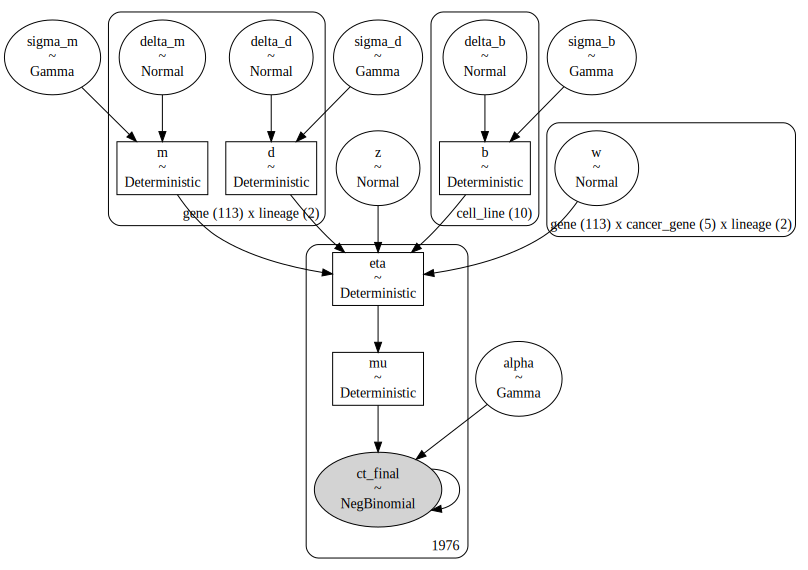

In [12]:
pm.model_to_graphviz(make_model(valid_counts_data, cancer_genes=cancer_genes))

## Sample posterior

In [13]:
with make_model(valid_counts_data, cancer_genes=cancer_genes):
    trace = pm.sample(draws=500, tune=200, chains=2, cores=2)
    _ = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [z, sigma_b, delta_b, sigma_d, delta_d, sigma_m, delta_m, w, alpha]


Sampling 2 chains for 200 tune and 500 draw iterations (400 + 1_000 draws total) took 91 seconds.
The acceptance probability does not match the target. It is 0.8929, but should be close to 0.8. Try to increase the number of tuning steps.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## Posterior analysis

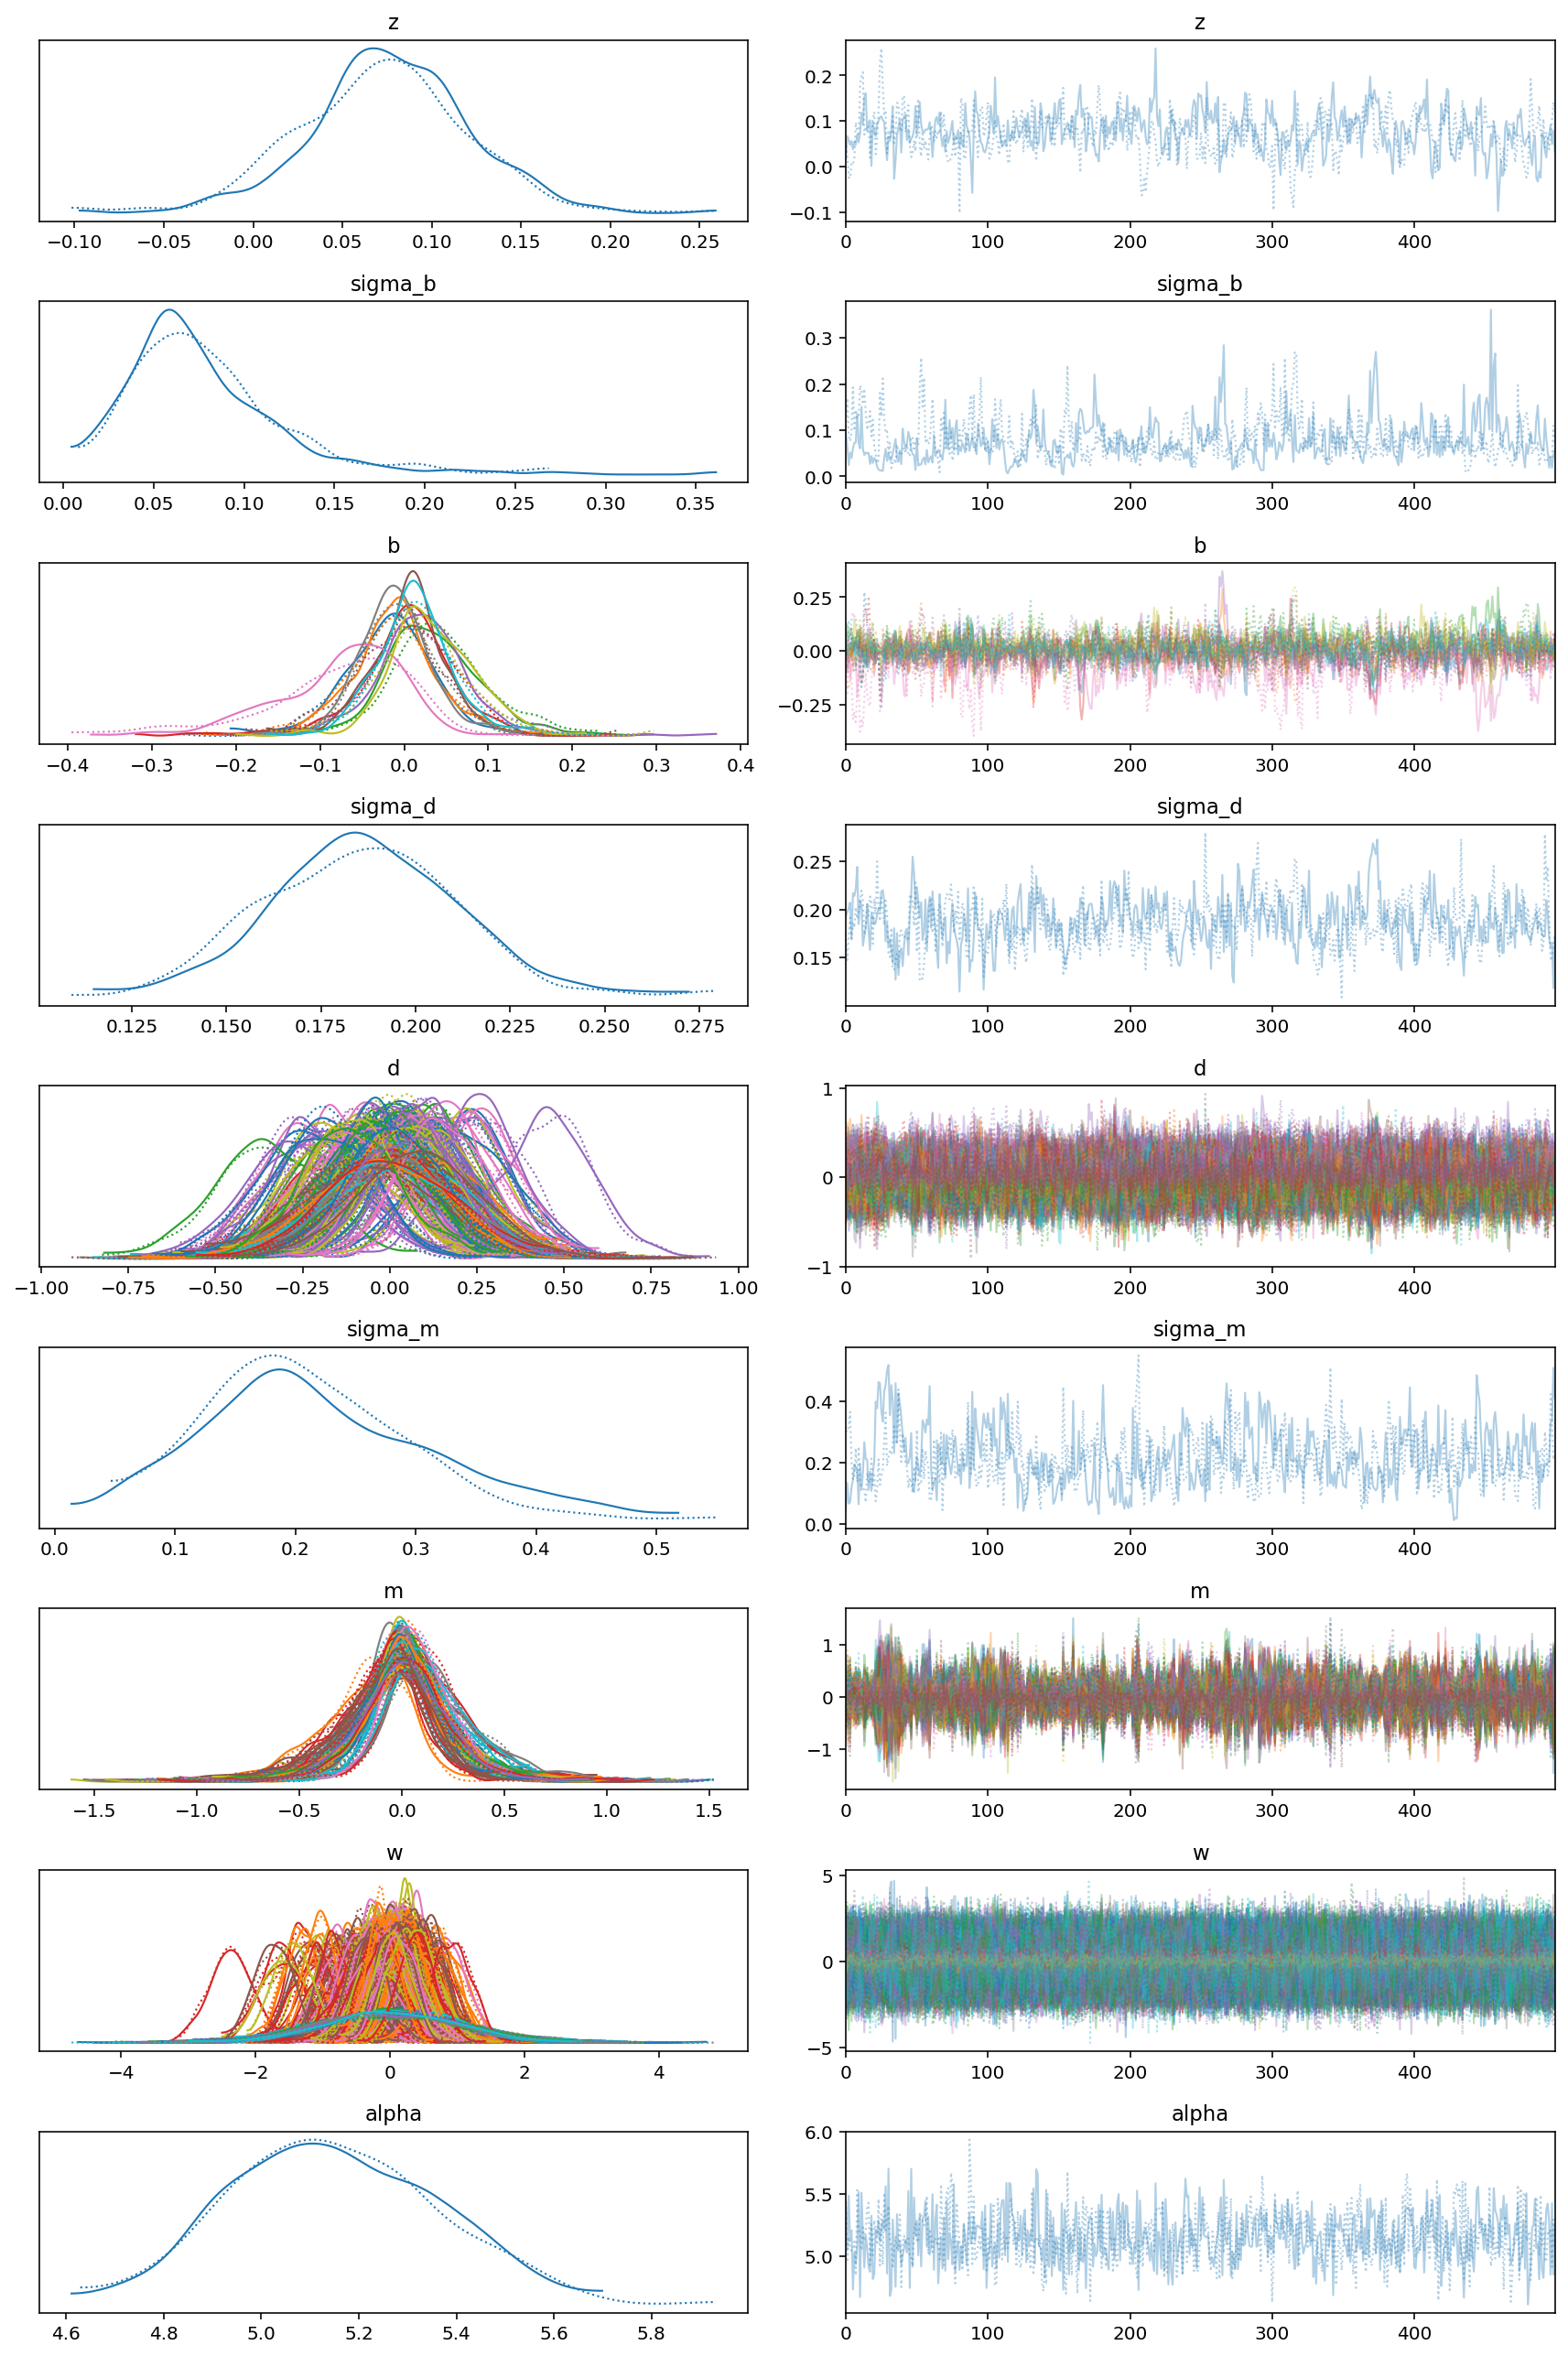

In [14]:
var_names = ["z", "sigma_b", "b", "sigma_d", "d", "sigma_m", "m", "w", "alpha"]
az.plot_trace(trace, var_names=var_names)
plt.tight_layout();

In [15]:
w_post = (
    az.summary(trace, var_names=["w"], kind="stats")
    .reset_index(drop=False)
    .rename(columns={"index": "param"})
    .assign(
        coords=lambda d: [
            x.replace("w[", "").replace("]", "").split(",") for x in d.param
        ]
    )
    .assign(
        hugo_symbol=lambda d: [x[0].strip() for x in d.coords],
        cancer_gene=lambda d: [x[1].strip() for x in d.coords],
        lineage=lambda d: [x[2].strip() for x in d.coords],
    )
)

The effect was captured by `w`.
Funny enough, I think the interaction between *MED4* and *KRAS* in colorectal is real; I only modified the values in bone.

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


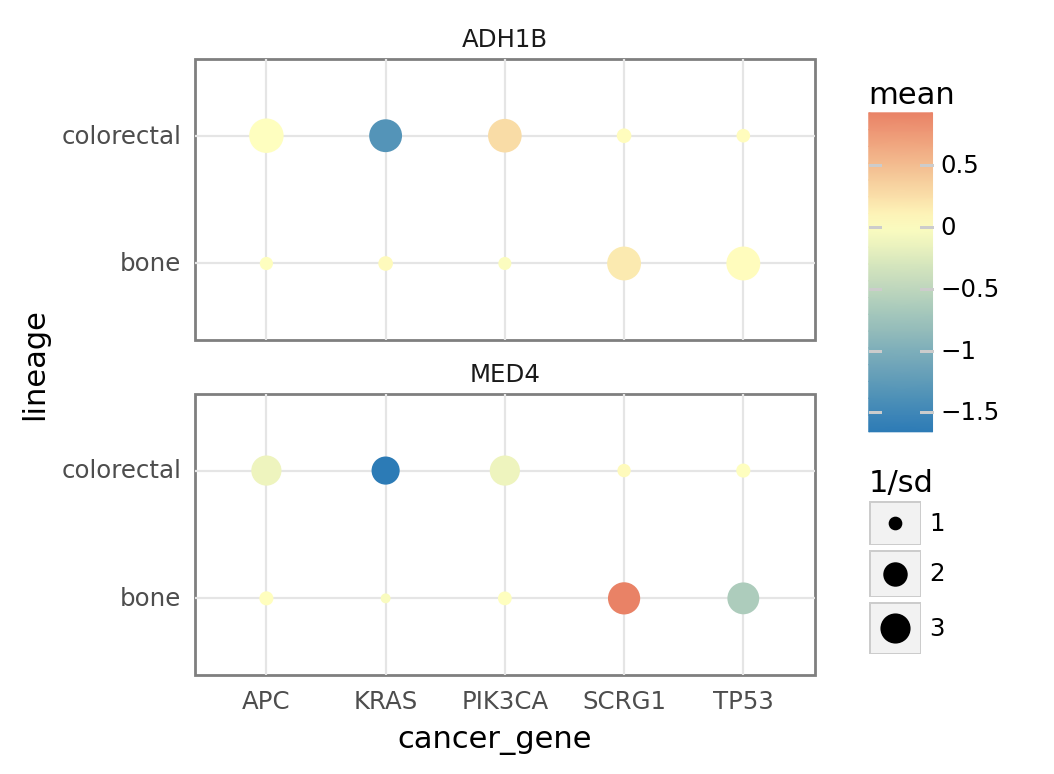

<ggplot: (323938567)>

In [16]:
(
    gg.ggplot(
        w_post.query("hugo_symbol == 'MED4' or hugo_symbol == 'ADH1B'"),
        gg.aes(x="cancer_gene", y="lineage"),
    )
    + gg.facet_wrap("~hugo_symbol", ncol=1)
    + gg.geom_point(gg.aes(color="mean", size="1/sd"))
    + gg.scale_color_gradient2(low="#2c7bb6", mid="#ffffbf", high="#d7191c")
    + gg.theme(figure_size=(4, 4))
)

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


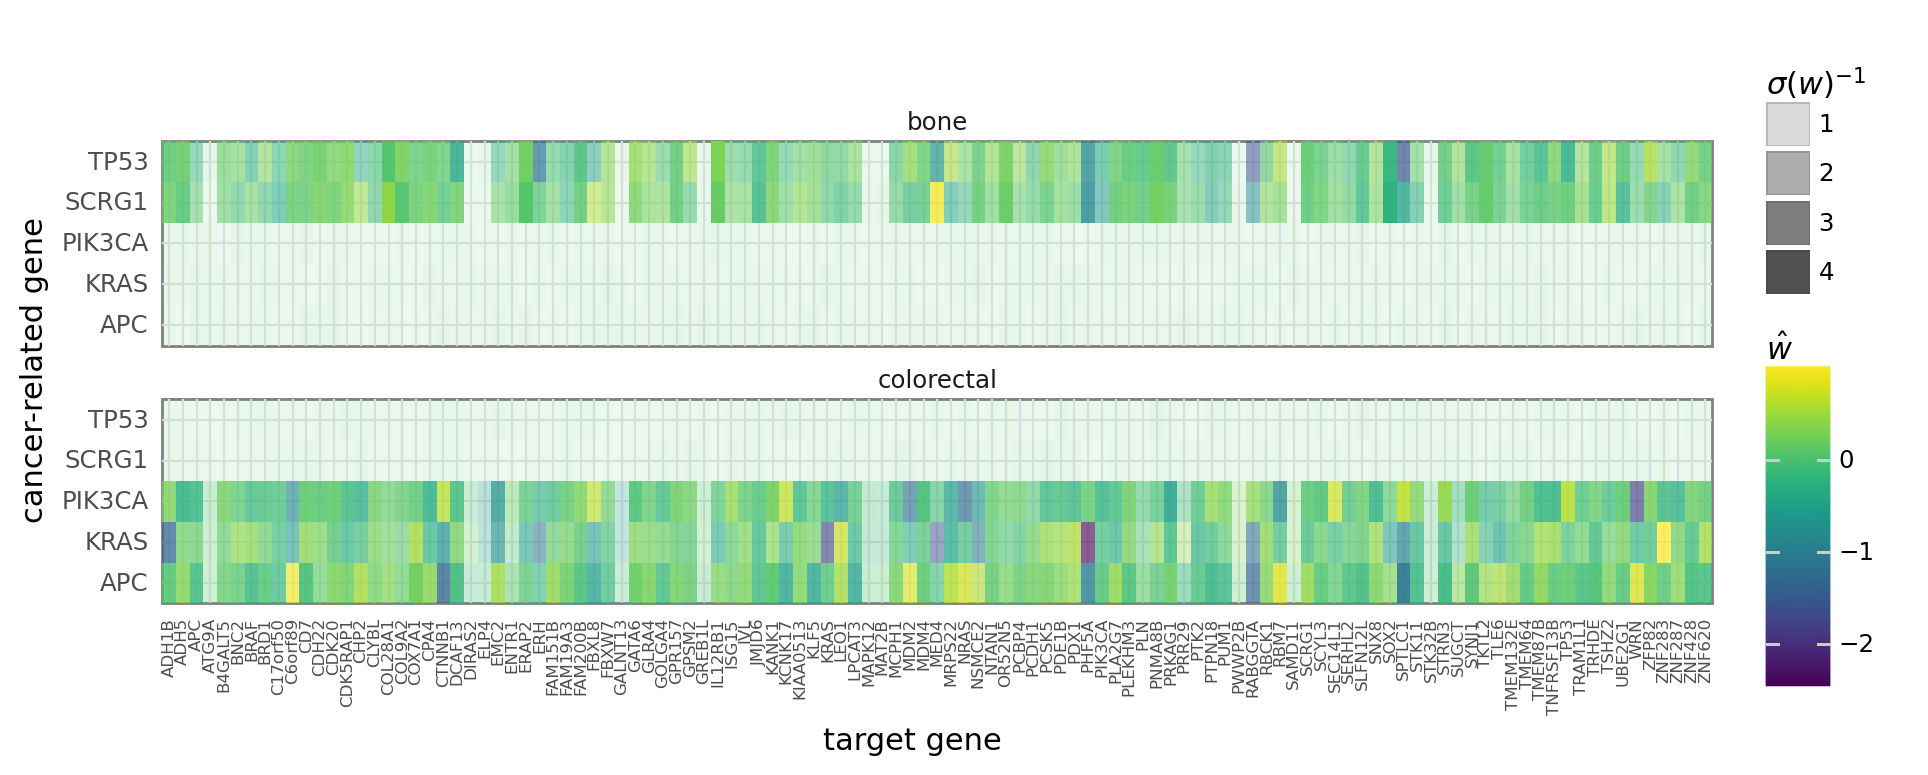

<ggplot: (324051508)>

In [17]:
(
    gg.ggplot(w_post, gg.aes(x="hugo_symbol", y="cancer_gene", fill="mean"))
    + gg.facet_wrap("~lineage", ncol=1)
    + gg.geom_tile(gg.aes(alpha="1/sd"), color=None)
    + gg.scale_x_discrete(expand=(0, 0.5))
    + gg.scale_y_discrete(expand=(0, 0.5))
    + gg.theme(figure_size=(10, 3), axis_text_x=gg.element_text(size=6, angle=90))
    + gg.labs(
        x="target gene",
        y="cancer-related gene",
        fill="$\hat{w}$",
        alpha="$\sigma(w)^{-1}$",
    )
)

Check the posteriors of $m$ and $w$ for the cancer genes when they are the target gene.
The mutation covariate $m$ has been augmented to skip the gene when it is a cancer gene.

In [18]:
m_post = (
    az.summary(trace, var_names=["m"], kind="stats")
    .reset_index(drop=False)
    .rename(columns={"index": "param"})
    .pipe(
        extract_matrix_variable_coords,
        col="param",
        idx1name="hugo_symbol",
        idx2name="lineage",
    )
)

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


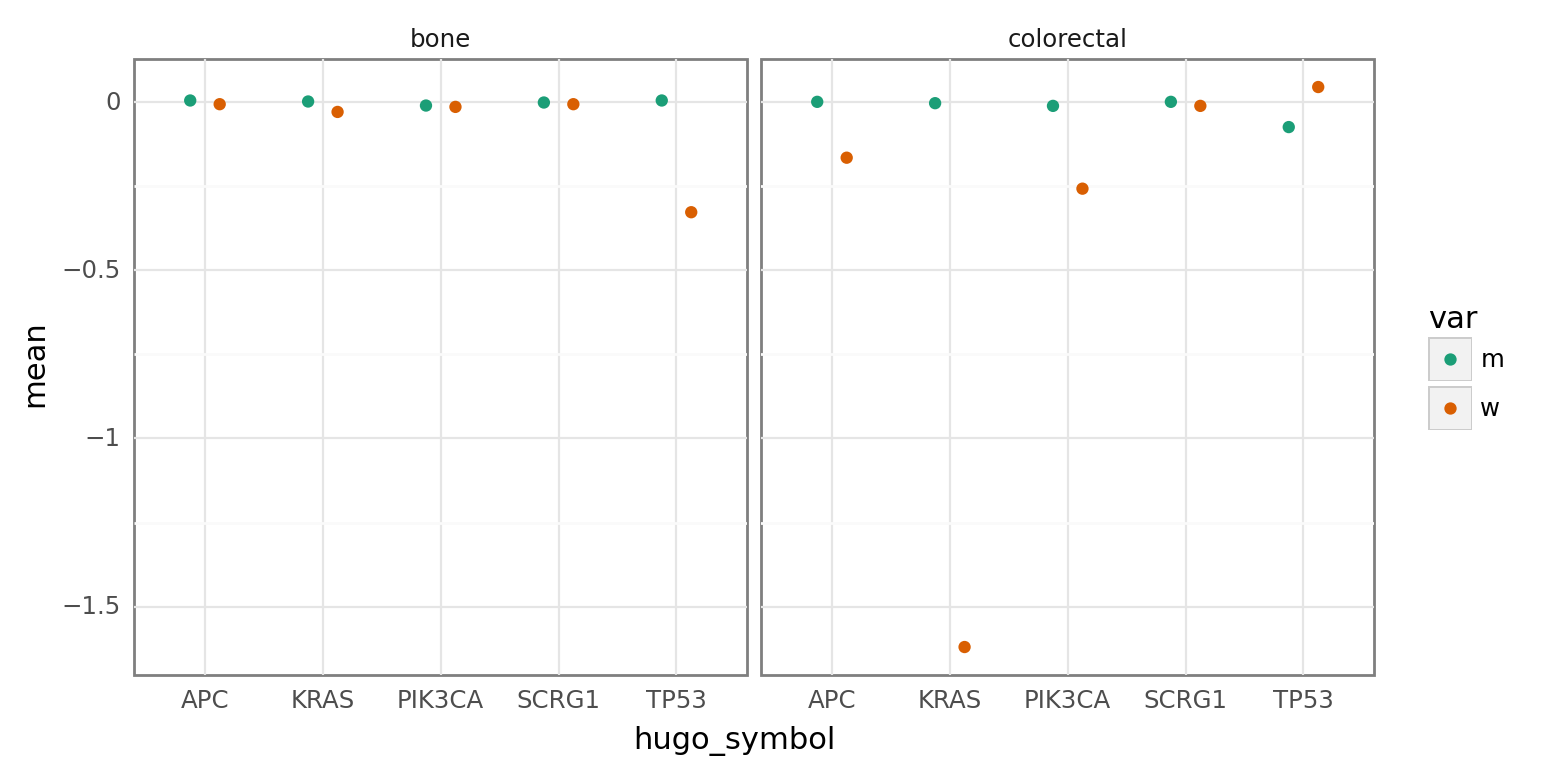

<ggplot: (324535125)>

In [19]:
plot_df = pd.concat(
    [
        w_post.query("hugo_symbol == cancer_gene").assign(var="w"),
        m_post.filter_column_isin(
            "hugo_symbol", _collect_all_cancer_genes(cancer_genes)
        ).assign(var="m"),
    ]
)

(
    gg.ggplot(plot_df, gg.aes(x="hugo_symbol", y="mean"))
    + gg.facet_wrap("~lineage", nrow=1)
    + gg.geom_point(gg.aes(color="var"), position=gg.position_dodge(width=0.5))
    + gg.scale_color_brewer(type="qual", palette="Dark2")
    + gg.theme(figure_size=(8, 4))
)

Just to make sure that the extreme positive distribution in `d` is not one of the genes being tested here.

In [20]:
az.summary(trace, var_names="d", kind="stats").sort_values(
    "mean", ascending=False
).head(10)

,mean,sd,hdi_3%,hdi_97%
"d[TP53, bone]",0.456,0.128,0.212,0.695
"d[SAMD11, bone]",0.269,0.123,0.048,0.502
"d[COX7A1, bone]",0.242,0.124,0.037,0.489
"d[PWWP2B, bone]",0.234,0.127,-0.010,0.459
"d[CLYBL, bone]",0.216,0.128,-0.028,0.454
"d[KCNK17, bone]",0.216,0.142,-0.065,0.470
"d[FAM19A3, bone]",0.211,0.134,-0.010,0.483
"d[GPR157, bone]",0.209,0.131,-0.021,0.473
"d[FAM151B, bone]",0.173,0.132,-0.063,0.415
"d[ZFP82, bone]",0.160,0.141,-0.067,0.457


---

In [21]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 3.30 minutes


In [22]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-03-28

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 8.1.1

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac

Git branch: oncogene-cov

pandas    : 1.4.1
plotnine  : 0.8.0
arviz     : 0.12.0
matplotlib: 3.5.1
janitor   : 0.22.0
pymc      : 4.0.0b5
numpy     : 1.22.3

